In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.random_projection import GaussianRandomProjection
import sys
sys.path.append('../')
sys.path.append('../src/')

from src.generative import *
from src.detection import *

X: (50000, 784)
X_val: (10000, 784)
X_test: (10000, 784)


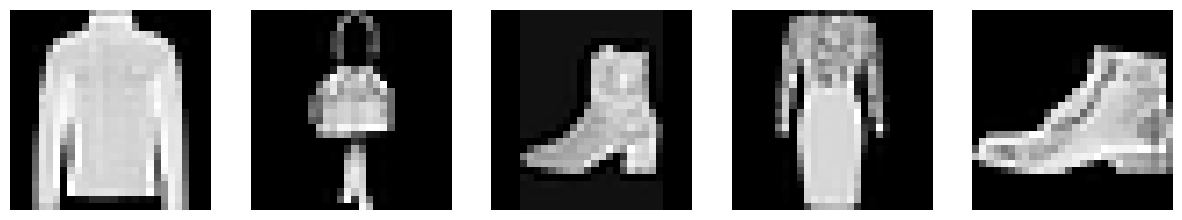

In [29]:
fmnist = FashionMNIST(root='../data.nosync/').fit()
X = fmnist.sample().detach().numpy().reshape(-1, 28*28)
X_val = fmnist.sample(10000, S='val').detach().numpy().reshape(-1, 28*28)
X_test = fmnist.sample(10000, S='test').detach().numpy().reshape(-1, 28*28)

# print shapes
print('X:', X.shape)
print('X_val:', X_val.shape)
print('X_test:', X_test.shape)

# plot some images
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(X[i].reshape(28, 28), cmap='gray')
    ax[i].axis('off')

## Synthetic Model

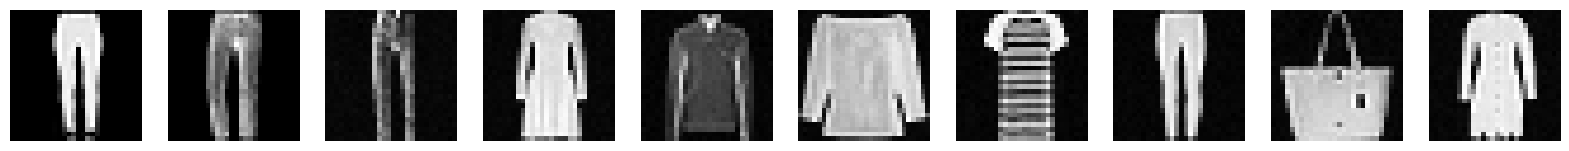

In [37]:
# q = rho * q_copying + (1 - rho) * q_underfit
copier = Memorizer()
underfitter = Memorizer(radius=0.5, n_copying=len(X))
q = Mixture(rho=0.2, q1=copier, q2=underfitter).fit(X)

# plot 10 images
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
samples = q.sample(10)
for i in range(10):
    ax[i].imshow(samples[i].reshape(28, 28), cmap='gray')
    ax[i].axis('off')

In [ ]:
# meehan
tst = ThreeSampleDetector(num_regions=50)
tst.C_T(Q=q, X_train=X, X_test=X_val)

In [31]:
X2 = q.sample(50000)
X3 = q.sample(50000)
print('X2:', X2.shape)
print('X3:', X3.shape)
k = 10
results = np.zeros((len(X3), k)).astype(bool)

for i in tqdm(range(k)):
    rp = GaussianRandomProjection(n_components=3).fit(X) # draw random projection
    dcd = DataCopyingDetector()
    idx = dcd.get_copying_indices(rp.transform(X), rp.transform(X2), rp.transform(X3))
    results[idx, i] = True

X2: (50000, 784)
X3: (50000, 784)


100%|██████████| 10/10 [00:36<00:00,  3.70s/it]


In [35]:
print(f"Majortiy Voting: {(results.mean(axis=1) > 0.5).mean()}")
print(f"Mean Aggregation: {results.mean(axis=1).mean()}")
print(f"Set Aggregation: {(results.any(axis=1)).mean()}")

Majortiy Voting: 0.24144
Mean Aggregation: 0.34253199999999995
Set Aggregation: 0.75472


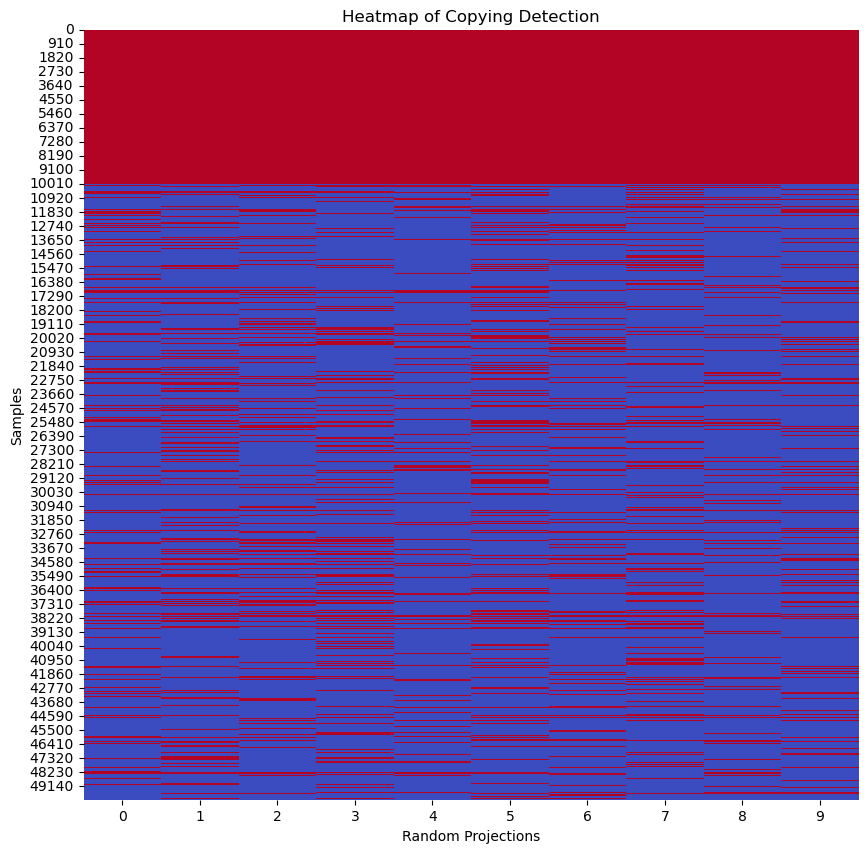

In [34]:
# heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(results, cmap='coolwarm', cbar=False)
plt.xlabel('Random Projections')
plt.ylabel('Samples')
plt.title('Heatmap of Copying Detection')
plt.show()